# SYBA - fragment preparation
On two sets of random ZINC compounds, Nonpher algorithm have been previously applied. Nonpher is used for generating hard-to-synthesize compounds. For more details see original paper https://dx.doi.org/10.1186%2Fs13321-017-0206-2 or source code https://github.com/lich-uct/nonpher. From one set, the ZINC compounds were selected as easy-to-synthesize and from the other set the Nonpher compounds as hard-to-synthesize. These selected compounds were used as training set for SYBA. However, it is possible to use Nonpher compounds and their corresponding starting compounds or possibly, SYBA can be trained for another classification problem with different compounds.

## Requirments to run this script are install SYBA, Jupyter and RDKit

In [1]:
import math
import gzip
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules+
from rdkit.Chem import Draw
from IPython.display import SVG
from syba import syba

## Processing files with compounds to obtain counts of fragment type

In [2]:
def processFile(path, smi_col=1):
    """
    For given compressed file, function returns number of all compounds and all Morgan fragment types with corresponding number of compounds
    in which they are found.
    
    path to data set (gzip csv file)
    smi_col is column where are SMILES, first column has index 0!
    """
    with gzip.open(path, mode="rt") as reader:
        suppl = syba.SmiMolSupplier(reader, header=True, smi_col=smi_col) # reads reader line by line and returns RDMol
        fs = {}
        n_of_compounds = 0
        for m, *spls in suppl:
            try:
                for frag in Chem.GetMorganFingerprint(m,2).GetNonzeroElements().keys():
                    d = fs.setdefault(frag, [0])
                    d[0] += 1
                n_of_compounds += 1
            except Exception as e:
                print(spls)
                raise e
        return fs, n_of_compounds

In [3]:
# resource files are compressed csv files in format ID,ZINC_SMILES,NONPHER_SMILES
infeasible_fragments, infeasible_compounds = processFile("../../syba/resources/structures_1.csv.gz", smi_col=2)
feasible_fragments, feasible_compounds = processFile("../../syba/resources/structures_2.csv.gz", smi_col=1)

In [4]:
list(feasible_fragments.items())[:10]

[(30958271, [151]),
 (98513984, [389669]),
 (203749390, [31988]),
 (422715066, [195054]),
 (545884714, [6013]),
 (847433064, [36362]),
 (864662311, [72059]),
 (951226070, [595384]),
 (1202540357, [537]),
 (1352098234, [254])]

## SYBA needs score for each fragment, these scores can be calculated from fragment counts so let's put all of them into one dictionary and then to file

In [5]:
def mergeFragmentCounts(feasible_fragments, infeasible_fragments):
    fragments = set(feasible_fragments.keys())
    fragments.update(infeasible_fragments.keys())
    fragment_counts = {}

    for f in fragments:
        fragment_counts[f] = (feasible_fragments.get(f, [0])[0], infeasible_fragments.get(f, [0])[0])
    return fragment_counts

In [6]:
fragment_counts = mergeFragmentCounts(feasible_fragments, infeasible_fragments)
# can be write into file with function from package and than loaded by SYBA
# arguments are: path to file, dictionary with fragment counts and collection with number of coumpounds in both sets
syba.writeCountFile("syba.csv", fragment_counts, (feasible_compounds, infeasible_compounds))

In [7]:
list(fragment_counts.items())[:10]

[(2852126722, (0, 1)),
 (3397386243, (0, 1)),
 (3573547011, (0, 1)),
 (2231369733, (0, 1)),
 (1484783622, (16, 3)),
 (1233125380, (0, 1)),
 (1132462088, (0, 1)),
 (369098763, (0, 1)),
 (1233125389, (0, 1)),
 (2600468497, (0, 1))]

## The most feasible and infeasible fragments

In [8]:
# score can be calculated with package function
# arguments are number of feasible compounds with fragment, infeasible compounds with fragment, number of feasible compounds and number of infeasible compounds
fragment_scores = {frg: syba.calculateScore(counts[0], counts[1], feasible_compounds, infeasible_compounds)[0] for frg, counts in fragment_counts.items()}

Get 10 fragment types with most "infeasible" (negative) and "feasible" (positive)

In [9]:
sorted_frgs = sorted(fragment_scores.items(), key=lambda k: k[1])
most_infeasible_fragments = sorted_frgs[:10]
most_feasible_fragments = sorted_frgs[-10:]

In [10]:
most_feasible_fragments

[(2099031818, 5.3612921657094255),
 (3501872999, 5.41610040220442),
 (3512128645, 5.44673737166631),
 (3931557395, 5.53338948872752),
 (3135046102, 5.556828061699537),
 (2207532114, 5.731721843345443),
 (2004485095, 6.0014148779611505),
 (2504217345, 6.0473721790462776),
 (3283681753, 6.113682179832232),
 (1312816494, 6.508769136971682)]

In [11]:
info={}
fp = Chem.GetMorganFingerprint(Chem.MolFromSmiles("c1ccccc1"),2,bitInfo=info)
[(i, info[i]) for i in info]

[(98513984, ((1, 1), (2, 1), (3, 1), (4, 1), (0, 1), (5, 1))),
 (2763854213, ((2, 2), (3, 2), (1, 2), (0, 2), (5, 2), (4, 2))),
 (3218693969, ((0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0)))]

In [12]:
def getFragmentEnv(m, frgs=set()):
    """
    Function returns environment (indices of atoms in compound) of provided fragment types
    """
    info={}
    fp = Chem.GetMorganFingerprint(m,2,bitInfo=info)
    env = [(i, info[i]) for i in info if i in frgs]
    return env

From training sets obtain compounds with desired fragment types and for each obtain its environment (atoms)

In [13]:
inf_ts = [] # list of tuples with RDMol and with fragment tuple (its ids and root atoms with size of neighbourhoods)
fea_ts = []

inf_frgs = {frg for frg, score in most_infeasible_fragments}
with gzip.open("../../syba/resources/structures_1.csv.gz", mode="rt") as reader:
    for mol, *spls in syba.SmiMolSupplier(reader, header=True, smi_col=2):
        r = getFragmentEnv(mol, inf_frgs)
        if r:
            inf_ts.append((mol, r))
            inf_frgs.remove(r[0][0])
            if not inf_frgs:
                break
del inf_frgs # should be empty

fea_frgs = {frg for frg, score in most_feasible_fragments}
with gzip.open("../../syba/resources/structures_2.csv.gz", mode="rt") as reader:
    for mol, *spls in syba.SmiMolSupplier(reader, header=True, smi_col=1):
        r = getFragmentEnv(mol, fea_frgs)
        if r:
            fea_ts.append((mol, r))
            fea_frgs.remove(r[0][0])
            if not fea_frgs:
                break
                
del fea_frgs # should be empty

In [14]:
fea_environments = []
fea_legends = []
fea_scores = []
fea_frgs = set()
for mol, ob in fea_ts:
    for frg, envs in ob:
        if frg not in fea_frgs:
            fea_environments.append((mol, envs[0][0], envs[0][1]))
            score = fragment_scores[frg]
            fea_scores.append(score)
            fea_legends.append("{} = {:.04f}".format(frg, score))
            fea_frgs.add(frg)
fea_environments, fea_legends, fea_scores = zip(*sorted(zip(fea_environments, fea_legends, fea_scores), key = lambda x: x[2], reverse= True))

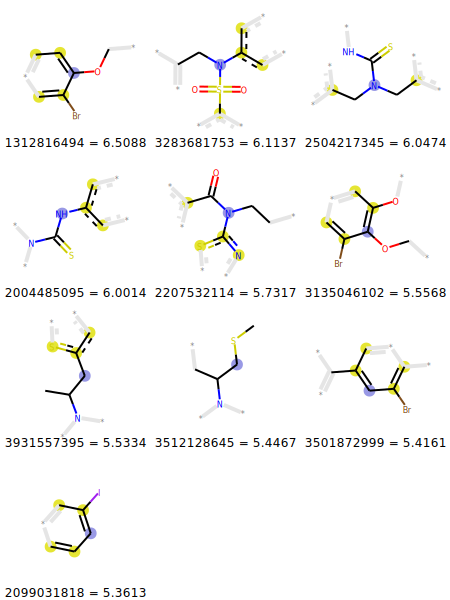

In [15]:
SVG(Draw.DrawMorganEnvs(fea_environments, legends=fea_legends, ))

In [16]:
inf_environments = []
inf_legends = []
inf_scores = []
inf_frgs = set()
for mol, ob in inf_ts:
    for frg, envs in ob:
        if frg not in inf_frgs:
            inf_environments.append((mol, envs[0][0], envs[0][1]))
            score = fragment_scores[frg]
            inf_scores.append(score)
            inf_legends.append("{} = {:.04f}".format(frg, score))
            inf_frgs.add(frg)
inf_environments, inf_legends, inf_scores = zip(*sorted(zip(inf_environments, inf_legends, inf_scores), key = lambda x: x[2]))

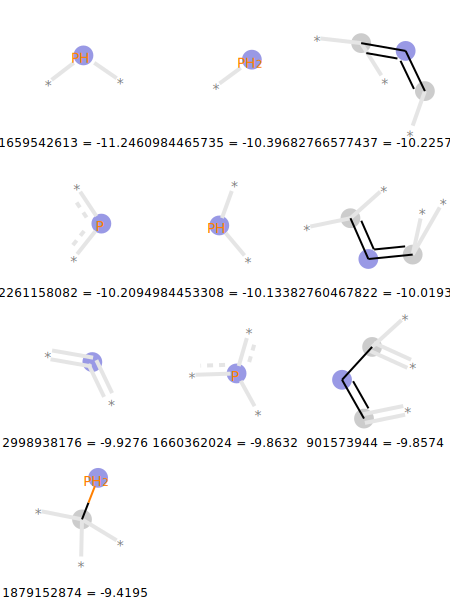

In [17]:
SVG(Draw.DrawMorganEnvs(inf_environments, legends=inf_legends, ))